In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import random

## 1. Number of transactions per day

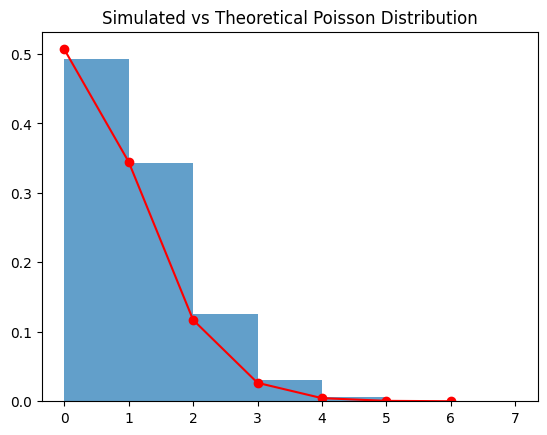

In [3]:
# 251 transactions per year = 0.68 transactions per day
daily_txn = np.random.poisson(0.68, size=1000)
plt.hist(daily_txn, bins=range(max(daily_txn)+2), density=True, alpha=0.7)
x = range(max(daily_txn)+1)
plt.plot(x, stats.poisson.pmf(x, 0.68), 'ro-')
plt.title('Simulated vs Theoretical Poisson Distribution')
plt.show()

## 2. Value of each transaction

In [4]:
def compute_sigma(mean:float, cv:float) -> float:
    """ 
    a formula to calculate sigma from mean and CV
    """
    variance = (mean * cv)**2
    sigma_sq = np.log(1 + variance/(mean**2))
    sigma = np.sqrt(sigma_sq)
    # get the value from numpy array
    return sigma.item()

In [5]:
compute_sigma(mean=96.49, cv=0.75)

0.6680472308365776

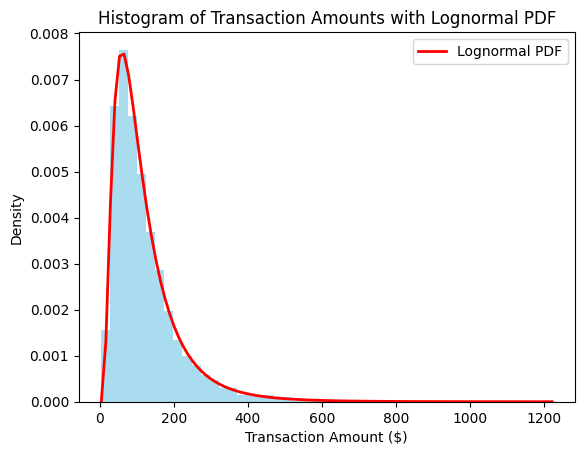

In [6]:
# Generate lognormal txn_value
mean = 96.49
sigma = 0.6873
size = 10000
txn_value = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)

# Create histogram
plt.hist(txn_value, bins=50, density=True, alpha=0.7, color='skyblue')

# Calculate PDF
x = np.linspace(txn_value.min(), txn_value.max(), 100)
pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean)))

# Plot PDF
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.title('Histogram of Transaction Amounts with Lognormal PDF')
plt.legend()
plt.show()

## 3. Consolidated Customer spending profile

In [132]:
# create a dictionary to contain profiles abvoe for the uniform distributions of mean and CV:
group_profiles = {
    'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
    'txn_mean_low': [5, 20, 40, 60, 80],
    'txn_mean_high': [20, 40, 60, 80, 100],
    'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
    'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
    'txn_lambda': [0.25, 0.5, 1, 1.5, 2] # to simplify, we assume middle income person has average 1 txn per day
}

# visualize in a table
df = pd.DataFrame(group_profiles)
df


,name,txn_mean_low,txn_mean_high,txn_cv_low,txn_cv_high,txn_lambda
0,low,5,20,0.3,0.4,0.25
1,low-middle,20,40,0.4,0.5,0.50
2,middle,40,60,0.5,0.6,1.00
3,high-middle,60,80,0.6,0.7,1.50
4,high,80,100,0.7,0.8,2.00


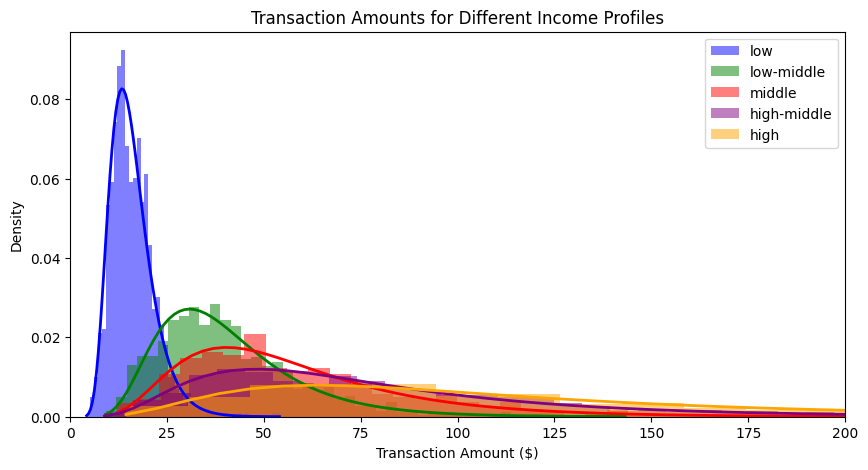

In [ ]:
# Illustrating the spending habit of the groups above by generate 1000 transactions for a customer of each profile

# Set seed for reproducibility
random.seed(99)
np.random.seed(99)

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(10, 5))
for i, profile in enumerate(df["name"]):
    row = df[df["name"] == profile].iloc[0]
    profile_dict = row.to_dict()

    mean_amount = np.random.uniform(profile_dict["txn_mean_low"], profile_dict["txn_mean_high"])
    cv = np.random.uniform(profile_dict["txn_cv_low"], profile_dict["txn_cv_high"])
    sigma = compute_sigma(mean_amount, cv)
    txn_value = np.random.lognormal(mean=np.log(mean_amount), sigma=sigma, size=1000)
    
    # Plot histogram
    plt.hist(txn_value, bins=50, density=True, alpha=0.5, label=profile, color=colors[i])
    
    # Calculate and plot PDF
    x = np.linspace(txn_value.min(), txn_value.max(), 100)
    pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean_amount)))
    plt.plot(x, pdf, color=colors[i], lw=2)

plt.xlim(0, 200)
plt.title('Transaction Amounts for Different Income Profiles')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [133]:
# create a class to generate customer:
class Customer():
    def __init__(self, profile:dict):
        self.profile = profile
    def generate_customer_txn(self, num_txn:int):
        pass

class CustomerGenerator():
    def __init__(self, group_profiles:dict):
        """
        Initialize the CustomerGenerator with a dictionary of group profiles.

        """
        self.group_profiles = self._convert_col_to_row_oriented_profile(group_profiles, 'name')

    def generate_customer_profile(self, profile_name:str):
        assert profile_name in self.group_profiles.keys(), 'Profile name not found'
        profile = self.group_profiles[profile_name]
        txn_mean = np.random.uniform(profile['txn_mean_low'], profile['txn_mean_high'])
        cv = np.random.uniform(profile['txn_cv_low'], profile['txn_cv_high'])
        txn_sigma = compute_sigma(txn_mean, cv)
        txn_lambda = profile['txn_lambda']
        customer_profile =  {
            'txn_mean': txn_mean,
            'txn_sigma': txn_sigma,
            'txn_lambda': txn_lambda}
        return Customer(customer_profile)

    def _convert_col_to_row_oriented_profile(self, input_dict: dict, key_field: str) -> dict:
        """
        Convert a column-oriented dictionary, which is more concise, to a row-oriented dictionary, which is easier to extract field-specific data from.

        Example:
        --------
        input_dict = {
            'key_field': ['A', 'B', 'C'],
            'field1': [1, 2, 3],
            'field2': [4, 5, 6]
        }
        output_dict = {
            'A': {'field1': 1, 'field2': 4},
            'B': {'field1': 2, 'field2': 5},
            'C': {'field1': 3, 'field2': 6}
        }
        """
        assert key_field in input_dict, f"Key field '{key_field}' not found in input dictionary"
        output_dict = {}
        key_values = input_dict[key_field]
        other_fields = {k: v for k, v in input_dict.items() if k != key_field}

        for i, key in enumerate(key_values):
            output_dict[key] = {field: values[i] for field, values in other_fields.items()}

        return output_dict

{'txn_mean': 97.74279809315495, 'txn_sigma': 0.6916930419886229, 'txn_lambda': 2}
Average total transaction value: $7028.92


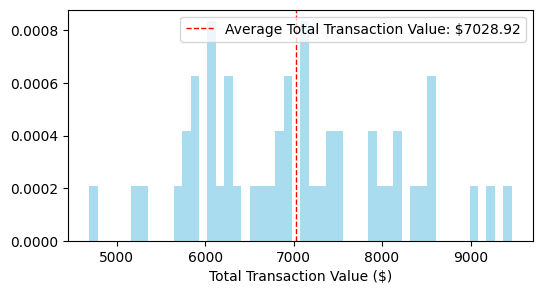

In [141]:
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_profile('high')
print(customer.profile)

# Trials to finetune the profiles
num_days =30
num_trials = 50
total_txn_values = []
for trial in range(num_trials):
    customer_txns = []
    for day in range(num_days):
        num_txn = np.random.poisson(customer.profile["txn_lambda"])
        if num_txn > 0:
            for txn in range(num_txn):
                time_txn = int(np.random.normal(86400 / 2, 20000))
                if (time_txn > 0) and (time_txn < 86400):
                    txn_value = round(np.random.lognormal(
                        mean=np.log(customer.profile["txn_mean"]),
                        sigma=customer.profile["txn_sigma"],
                    ),2)
                    customer_txns.append(
                        {
                            "day": day,
                            "time_seconds": time_txn + day * 86400,
                            "txn_value": txn_value,
                        }
                    )
    total_txn_values.append(round(sum([txn["txn_value"] for txn in customer_txns]),2))
# average total transaction value over all trials
avg_total_txn_value = round(np.mean(total_txn_values),2)
print(f"Average total transaction value: ${avg_total_txn_value}")
# Plot histogram
plt.figure(figsize=(6,3))
plt.hist(total_txn_values, bins=50, density=True, alpha=0.7, color='skyblue')
plt.xlabel('Total Transaction Value ($)')
# add average total transaction value to the plot
plt.axvline(avg_total_txn_value, color='red', linestyle='dashed', linewidth=1, label=f'Average Total Transaction Value: ${avg_total_txn_value}')
plt.legend()

In [ ]:
num_days = 30
customer_txns = []
start_date = "2024-01-01"
for day in range(num_days):
    num_txn = np.random.poisson(customer.profile["txn_lambda"])
    if num_txn > 0:
        for txn in range(num_txn):
            # Time of transaction: revolves around noontime, with std 20000 seconds. This is meant to simulate the fact that most transactions should occur during the day (e.g., grocery, gas, other shopping...)
            time_txn = int(np.random.normal(86400 / 2, 20000))
            
            if (time_txn > 0) and (time_txn < 86400):
                txn_value = round(np.random.lognormal(
                    mean=np.log(customer.profile["txn_mean"]),
                    sigma=customer.profile["txn_sigma"],
                ), 2)

                # Add day offset to start_date
                datetime_txn = pd.to_datetime(time_txn, unit='s', origin=pd.Timestamp(start_date) + pd.Timedelta(days=day))
                
                customer_txns.append(
                    {
                        "day": day,
                        "time_seconds": time_txn + day * 86400,
                        "datetime": datetime_txn,
                        "txn_value": txn_value,
                    }
                )
# compute total value of transactions
total_txn_value = round(sum([txn["txn_value"] for txn in customer_txns]), 2)
print(f"Total transaction value: ${total_txn_value}")
customer_txns

Total transaction value: $10307.93


[{'day': 2,
  'time_seconds': 198866,
  'datetime': Timestamp('2024-01-03 07:14:26'),
  'txn_value': 106.75},
 {'day': 3,
  'time_seconds': 293296,
  'datetime': Timestamp('2024-01-04 09:28:16'),
  'txn_value': 27.79},
 {'day': 3,
  'time_seconds': 299738,
  'datetime': Timestamp('2024-01-04 11:15:38'),
  'txn_value': 46.04},
 {'day': 3,
  'time_seconds': 322375,
  'datetime': Timestamp('2024-01-04 17:32:55'),
  'txn_value': 44.01},
 {'day': 3,
  'time_seconds': 302991,
  'datetime': Timestamp('2024-01-04 12:09:51'),
  'txn_value': 130.25},
 {'day': 3,
  'time_seconds': 298190,
  'datetime': Timestamp('2024-01-04 10:49:50'),
  'txn_value': 126.9},
 {'day': 3,
  'time_seconds': 283803,
  'datetime': Timestamp('2024-01-04 06:50:03'),
  'txn_value': 292.23},
 {'day': 4,
  'time_seconds': 381610,
  'datetime': Timestamp('2024-01-05 10:00:10'),
  'txn_value': 82.41},
 {'day': 4,
  'time_seconds': 387770,
  'datetime': Timestamp('2024-01-05 11:42:50'),
  'txn_value': 72.83},
 {'day': 4,
  't

In [ ]:
# sample of 1 customer in 1 profile
profile = "middle"

# get the row of the profile
row = df[df["name"] == profile].iloc[0]
# convert to dictionary for easy access
profile_dict = row.to_dict()
# generate random txn amount
mean_amount = np.random.uniform(profile_dict["mean_low"], profile_dict["mean_high"])
cv = np.random.uniform(profile_dict["cv_low"], profile_dict["cv_high"])
sigma = compute_sigma(mean_amount, cv)

# generate txn value for that customer
txn_value = round(np.random.lognormal(mean=np.log(mean_amount), sigma=sigma, size=1).item(),2)

txn_value

69.89

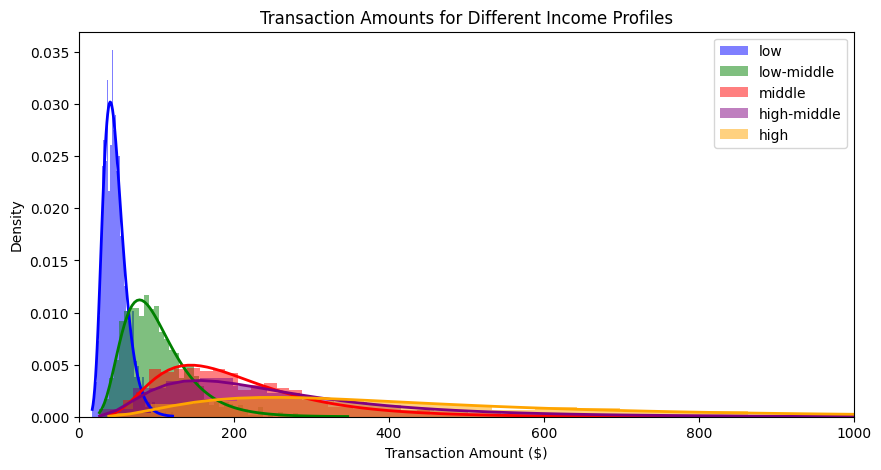

In [ ]:
# generate 5 customers for a profile:
n_customers = 5
customer_ids = []
